In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import mmcv
import importlib
import torch
import torchvision.transforms as transforms
from mmcv import Config
from mmcls.datasets.pipelines import Compose
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from PIL import Image
import heapq
from mmseg.apis import inference_segmentor, init_segmentor
from mmseg.core.evaluation import get_palette
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

from scripts import generate_statistics_single
from scripts import visualization_seg_masks
from scripts import generate_statistics
from scripts import generate_cams
from scripts import utils
from scripts.utils.pipeline import get_pipeline_torchvision
from scripts import generate_segs

In [2]:
configSeg = '../segmentation/ocrnet_hr48_512x512_carparts_noflip/ocrnet_hr48_512x512_carparts_noflip.py'
checkpointSeg = '../segmentation/ocrnet_hr48_512x512_carparts_noflip/latest.pth'
imgRootTrain = '../data/CompCars_sv_original_split/train'
imgRootVal = '../data/CompCars_sv_original_split/val'
configCAMResOG = '../CAMModels/resnet/compCars_Original/resnet50_b128x2_compcars-original-split.py'
checkpointCAMResOG = '../CAMModels/resnet/compCars_Original/latest.pth'
configCAMSwinSmallOG = '../CAMModels/swinSmall/compCars_Original/swin-small_b128x2_compcars-original-split.py'
checkpointCAMSwinSmallOG = '../CAMModels/swinSmall/compCars_Original/latest.pth'
annfileTrain = '../annfileTrain.txt'
annfileVal = '../annfileVal.txt'
annfileValGt = '../annfileValGt.txt'
imgNameTrain='Acura_Acura_ILX_2a6cce617fc27d.jpg'
imgNameVal = 'Acura_Acura_ILX_3c11ef9e42931b.jpg'
imgPathTrain=os.path.join(imgRootTrain, imgNameTrain)
imgPathVal=os.path.join(imgRootVal, imgNameVal)

paletteName='Comp_Original_Ocrnet_Carparts_Noflip'

segDataPath = '../preGenData/valAllSeg.npz'

camDataGradCAM = '../preGenData/CompCars_original/ResNet/valAllCAMs.npz'
camDataEigenCAM = '../preGenData/CompCars_original/ResNet/valAllCAMsEigen.npz'
camDataEigenGrad = '../preGenData/CompCars_original/ResNet/valAllCAMsEigenGrad.npz'
camDataGradCAMGPU = '../preGenData/CompCars_original/ResNet/valAllCAMsGPU.npz'
camDataGradCAMPlusPlus = '../preGenData/CompCars_original/ResNet/valAllCAMsGrad++.npz'
camDataLayerCAM = '../preGenData/CompCars_original/ResNet/valAllCAMsLayer.npz'
camDataXCAM = '../preGenData/CompCars_original/ResNet/valAllCAMsXGrad.npz'

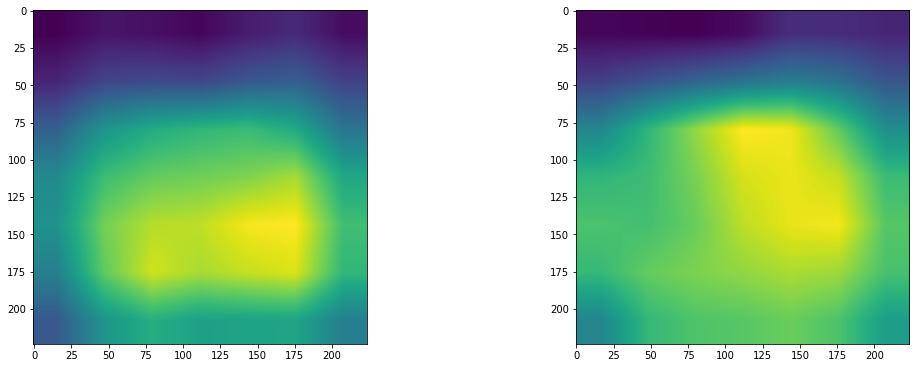

In [9]:
fig = plt.figure(figsize=(15,5),constrained_layout=True)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.imshow(c['Acura_Acura_ILX_3c11ef9e42931b.jpg'])
ax2.imshow(g['Acura_Acura_ILX_3c11ef9e42931b.jpg'])

In [226]:
def custom_mean(arr_in):
    n_samples = sum([x.shape[0] for x in arr_in])
    r = [sum([sum(batch[:,i])/n_samples for batch in arr_in]) for i in range(arr_in[0].shape[-1])]
    return np.array(r)
def custom_var(arr_in, mean_in):
    segmentSeperatedSamples = np.concatenate([[batch[:,sample].flatten() for sample in range(batch.shape[-1])] for batch in arr_in], axis=1)
    # Since mean is already calculated we can utilize it here and save some calculation power
    # Alternativly one could directly return np.var(segmentSeperatedSamples, axis=1)
    # This could introduce rounding risks when calculating the mean
    assert segmentSeperatedSamples.shape[0] == mean_in.shape[0]
    meanNormalized = [segmentSeperatedSamples[i] - mean_in[i] for i in range(segmentSeperatedSamples.shape[0])]
    return np.mean(np.abs(meanNormalized)**2, axis=1)

In [27]:
a = np.random.randint(40000,size=(20000))
print(a)

[25368 34652  5353 ... 12991  7712 20361]


In [28]:
a.sum()

401614025

In [16]:
a.mean()

52742302.86

In [17]:
total = 0
splice = 10
for i in range(int(len(a)/splice)+1):
    s = a[splice*i:splice*(i+1)].sum()
    print(s)
    total += s / len(a)
print(f'Total Mean:{total}')

549215818
521801359
573142598
502151784
490803584
0
Total Mean:52742302.86


In [32]:
a.mean()

47261855.2

In [14]:
a.dtype

dtype('int32')

Using given Segmentation Data.
Loading data from file at ../preGenData/valAllSeg.npz
Using given CAM Data.
Loading data from file at ../preGenData/CompCars_original/ResNet/valAllCAMs.npz
Accumulating Statistics for given imgNames.
Generate Statistics Data


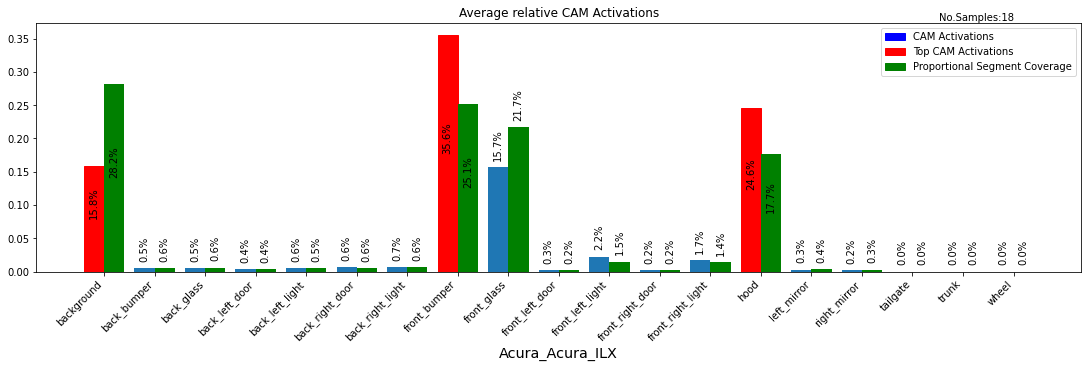

Output path is not a directory. Using base directory: ./results.
Saving images to: ./results\Multiple_classes_valAllCAMs_CAM-Predefined_CAM-Predefined_SEG-Predefined_valAllSeg_ShowPropArea_09_08_2022.jpg
Writing data to file at ./results/dataClasses\Multiple_classes_valAllCAMs_CAM-Predefined_CAM-Predefined_SEG-Predefined_valAllSeg_ShowPropArea_09_08_2022.jpg


In [8]:
generate_statistics.generate_statistic_prop(imgRoot=imgRootVal, camData=camDataGradCAM, segConfig=configSeg,
                       segCheckpoint=checkpointSeg, segData=segDataPath, dataClasses=['Acura_Acura_ILX'],
                        showPropPercent=True)

Using given Segmentation Data.
Loading data from file at ../preGenData/valAllSeg.npz
Using given CAM Data.
Loading data from file at ../preGenData/CompCars_original/ResNet/valAllCAMs.npz


C:\Users\Linus\Desktop\XAI-Vehicle-Classification\scripts\utils\prepareData.py:101: UserWarning: No pipeline is applied since segData is provided. If pipeline should be applied specify by pipelineCfg parameter.
  warnings.warn('No pipeline is applied since segData is provided. If pipeline should be applied specify '


Accumulating Statistics for given imgNames.
Generate Statistics Data


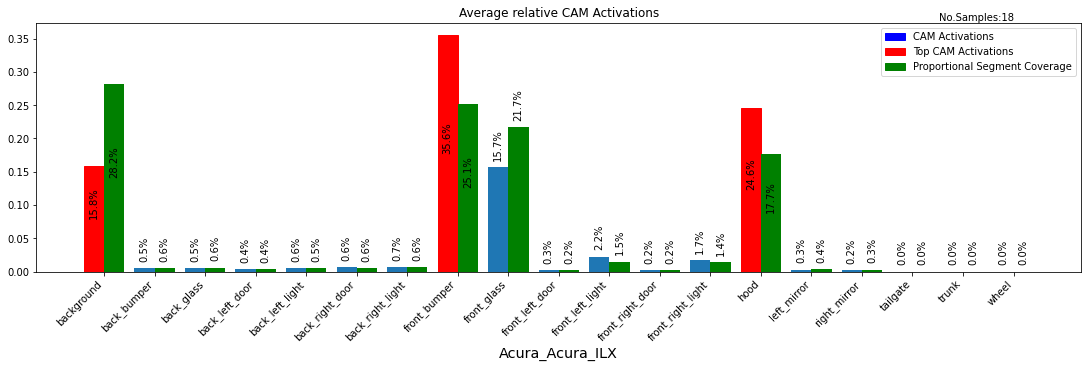

Output path is not a directory. Using base directory: ./results.
Saving images to: ./results\Multiple_classes_valAllCAMs_CAM-Predefined_CAM-Predefined_SEG-Predefined_valAllSeg_ShowPropArea_09_08_2022.jpg
Writing data to file at ./results/dataClasses\Multiple_classes_valAllCAMs_CAM-Predefined_CAM-Predefined_SEG-Predefined_valAllSeg_ShowPropArea_09_08_2022.jpg


In [3]:
generate_statistics.generate_statistic_prop(imgRoot=imgRootVal, camData=camDataGradCAM, segConfig=configSeg,
                       segCheckpoint=checkpointSeg, segData=segDataPath, dataClasses=['Acura_Acura_ILX'],
                        showPropPercent=True)

Using given Segmentation Data.
Loading data from file at ../preGenData/valAllSeg.npz
Using given CAM Data.
Loading data from file at ../preGenData/CompCars_original/ResNet/valAllCAMs.npz


C:\Users\Linus\Desktop\XAI-Vehicle-Classification\scripts\utils\prepareData.py:101: UserWarning: No pipeline is applied since segData is provided. If pipeline should be applied specify by pipelineCfg parameter.
  warnings.warn('No pipeline is applied since segData is provided. If pipeline should be applied specify '


Accumulating Statistics for given imgNames.
Generate Statistics Data
[0.56093425 0.88383296 0.79256213 1.07660086 1.13509485 1.12669095
 1.14156874 1.41589578 0.72429267 1.32029162 1.51567712 1.21268906
 1.19757815 1.39063159 0.75786967 0.63819825 0.         0.
 0.        ]
++++++++++++++++++++++++++++++
[0.15824409 0.00501137 0.00487998 0.00421739 0.00571338 0.00645201
 0.00722227 0.35583951 0.15721766 0.00271318 0.02244899 0.00229334
 0.01669933 0.24609139 0.00303763 0.00191848 0.         0.
 0.        ]
++++++++++++++++++++++++++++++
[0.08876453 0.00442921 0.00386768 0.00454045 0.00648523 0.00726942
 0.00824472 0.50383165 0.1138716  0.00358219 0.03402543 0.00278111
 0.01999875 0.34222246 0.00230213 0.00122437 0.         0.
 0.        ]


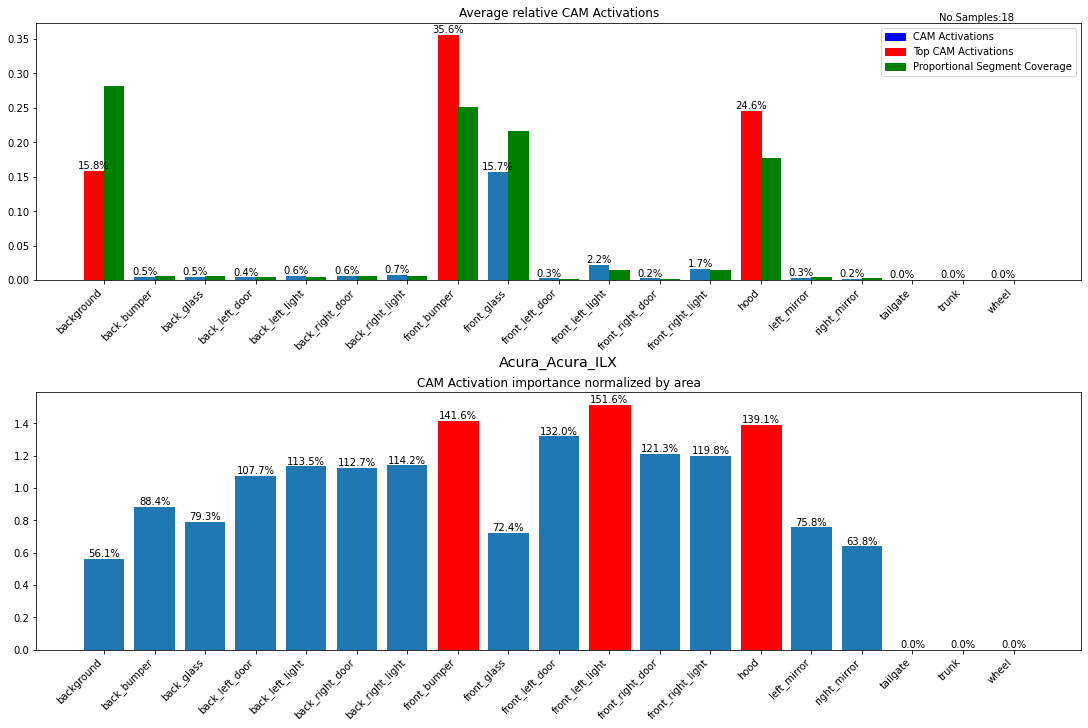

Output path is not a directory. Using base directory: ./results.
Saving images to: ./results\Multiple_classes_valAllCAMs_CAM-Predefined_CAM-Predefined_SEG-Predefined_valAllSeg_ShowPropArea_AreaNormalized_09_08_2022.jpg
Writing data to file at ./results/dataClasses\Multiple_classes_valAllCAMs_CAM-Predefined_CAM-Predefined_SEG-Predefined_valAllSeg_ShowPropArea_AreaNormalized_09_08_2022.jpg


In [6]:
generate_statistics.generate_statistic_prop_normalized(imgRoot=imgRootVal, camData=camDataGradCAM, segConfig=configSeg,
                       segCheckpoint=checkpointSeg, segData=segDataPath, dataClasses=['Acura_Acura_ILX'],
                        showPropPercent=True)

Using given Segmentation Data.
Loading data from file at ../preGenData/valAllSeg.npz
Using given CAM Data.
Loading data from file at ../preGenData/CompCars_original/ResNet/valAllCAMs.npz


C:\Users\Linus\Desktop\XAI-Vehicle-Classification\scripts\utils\prepareData.py:101: UserWarning: No pipeline is applied since segData is provided. If pipeline should be applied specify by pipelineCfg parameter.
  warnings.warn('No pipeline is applied since segData is provided. If pipeline should be applied specify '


Accumulating Statistics for given imgNames.
Generate Statistics Data


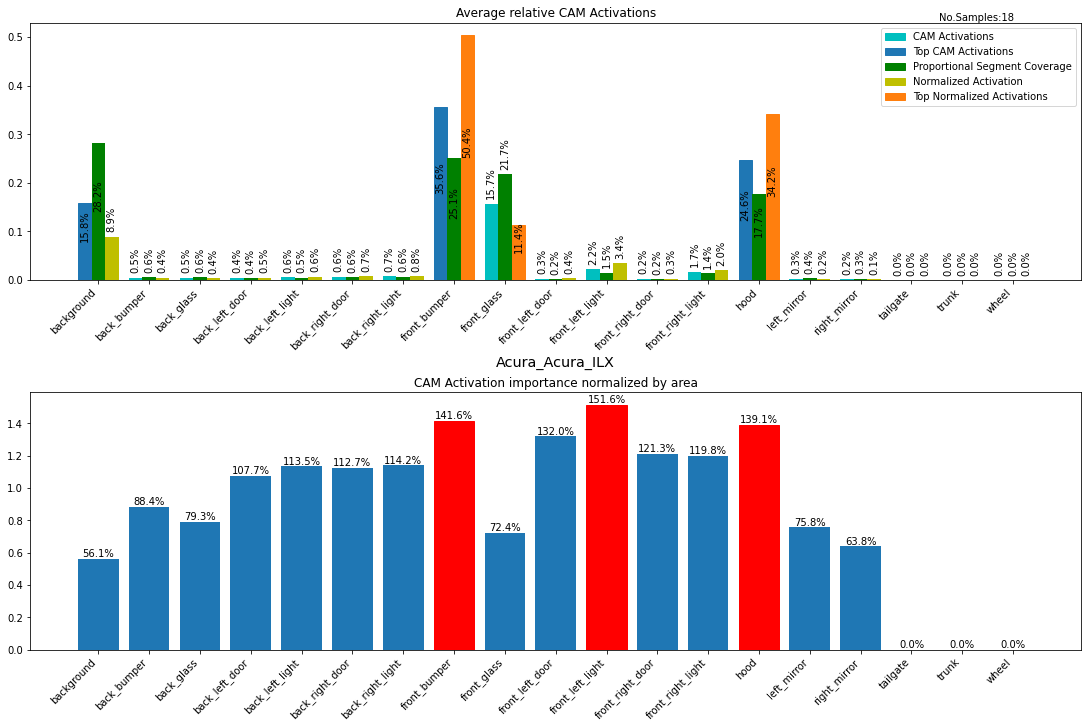

Output path is not a directory. Using base directory: ./results.
Saving images to: ./results\Multiple_classes_valAllCAMs_CAM-Predefined_CAM-Predefined_SEG-Predefined_valAllSeg_ShowPropArea_AreaNormalized_09_08_2022.jpg
Writing data to file at ./results/dataClasses\Multiple_classes_valAllCAMs_CAM-Predefined_CAM-Predefined_SEG-Predefined_valAllSeg_ShowPropArea_AreaNormalized_09_08_2022.jpg


In [41]:
generate_statistics.generate_statistic_prop_normalized(imgRoot=imgRootVal, camData=camDataGradCAM, segConfig=configSeg,
                       segCheckpoint=checkpointSeg, segData=segDataPath, dataClasses=['Acura_Acura_ILX'],
                        showPercent=True)